# **RenAIssance: OCR for Seventeenth Century Spanish Texts**

## **Overview**
RenAIssance project aims to utilize optical character recognition (OCR) to digitize text sources not yet addressed by current tools. The competition leverages machine learning techniques to enable OCR on various undigitized materials. Specifically, it focuses on AI applications to recognize text in seventeenth-century Spanish printed sources, a niche largely ignored by existing OCR solutions.

Current OCR tools, like Adobe Acrobat’s OCR, struggle with transliteration from historical texts. These tools can recognize text from modern, clearly printed sources but fail with early print forms and manuscripts.

<p align="center">
<img src="https://github.com/ML4SCI/DeepLearnHackathon/blob/Renaissance/NLPRenaissanceChallenge/images/book_header.png?raw=true">
</p>

## **Objective**
Build and evaluate a model to recognize text in scanned pages from historical Spanish texts. The aim is to improve transcription accuracy on low-resource, early print data that traditional OCR tools cannot handle.

This notebook demonstrates the use of Convolutional-Recurrent Neural Network (CRNN) architectures to solve the problem of Optical Character Recognition (OCR) for seventeenth-century Spanish texts. The model is trained on the given dataset, with transcriptions available for the first 25 pages. The remaining 6 pages are used for testing the model's performance. The goal is to improve the accuracy of the OCR model to achieve good results.

<p align="center">
<img src="https://github.com/ML4SCI/DeepLearnHackathon/blob/Renaissance/NLPRenaissanceChallenge/images/crnn_architecture.png?raw=true">
</p>

## **Dataset**
We use with two digitized books:
- Nobleza Virtuosa
- Noble Perfecto

Each dataset contains:
- Scanned page images (~31 pages each).
- Ground truth transcriptions (.docx) for the first 25 pages.
- Preprocessed bounding boxes aligned to the text for training.

The last 6 pages are reserved for testing (no transcription provided).

Datasets have been preprocessed, split, and merged, allowing the model to be trained either per-book or on a combined dataset.
- You need to submit the predicted text for the remaining 6 pages as the output of your model for testing purposes.

## **Task**
Train an OCR model to learn from the transcribed pages and generalize to unseen pages. The final output should be predicted transcriptions for the test pages.

## **Evaluation Metrics**
Outline the evaluation metrics used to assess your model's performance. Consider the following:
- Character Error Rate (CER)
- Word Error Rate (WER)
- Precision, Recall, and F1 Score for text recognition

## **Deliverables**
- A trained OCR model
- Transcription outputs for the 6 test pages (plain text files)
- A brief report covering:
    - Model architecture and training approach
    - Preprocessing steps
    - Evaluation results
- A usage notebook demonstrating the inference pipeline
- Completion of pre- and post-hackathon surveys

# Installs the necessary packages, may ask the users to please restart the notebook

In [ ]:
%pip install scikit-image PyMuPDF python-docx opencv-python scipy torch torchvision==0.2.1 pillow==8.3.1 natsort fitz

Note: you may need to restart the kernel to use updated packages.


You will be prompted to Restart the session. Continue running the cells after restarting

# Imports the necessary modules

In [2]:
# Data Pre-processing
import fitz
import cv2
import csv
import os
from docx import Document
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output as cls
from pathlib import Path

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

# Configuration (File Paths for Individual Datasets)

In [3]:
# Define paths for image folders and outputs
image_folders = {
    "Nobleza Virtuosa": {
        "pdf": Path("data/Padilla - Nobleza virtuosa_testExtract.pdf"),
        "input": Path("content/preprocessing/imgsUnProcessed"),
        "output": Path("content/preprocessing/imgsForAllPages"),
        "processed": Path("content/preprocessing/imgsProcessed"),
        "bounding_boxes": Path("content/preprocessing/BoundBoxApplied"),
        "bounding_boxes_sorted": Path("content/preprocessing/BoundBoxApplied_sorted"),
        "gt_docx": Path("data/Padilla - 1 Nobleza virtuosa_testTranscription.docx"),
        "text_file": Path("content/NoblezaVirtuosa_all_text.txt"),
        "split_text_output": Path("content/preprocessing/textSplitted_NoblezaVirtuosa"),
    },

    "Noble Perfecto": {
        "pdf": Path("data/Padilla - 2 Noble perfecto_Extract.pdf"),
        "input": Path("content/preprocessing/imgsUnProcessed2"),
        "output": Path("content/preprocessing/imgsForAllPages2"),
        "processed": Path("content/preprocessing/imgsProcessed2"),
        "bounding_boxes": Path("content/preprocessing/BoundBoxApplied2"),
        "bounding_boxes_sorted": Path("content/preprocessing/BoundBoxApplied_sorted2"),
        "gt_docx": Path("data/Padilla - 2 Noble perfecto_Transcription.docx"),
        "text_file": Path("content/NoblePerfecto_all_text.txt"),
        "split_text_output": Path("content/preprocessing/textSplitted_NoblePerfecto")
    }
}


# Downloading the dataset
#### Includes both books and their transcriptions
- Padilla - Nobleza Virtuosa
- Padilla - Noble Perfecto

In [18]:
PDF_DIR = Path("data")
FOLDER_ID ='195Bh7_Fz2NUWrfkL_t_GUJj4u3GlkjG8?fbclid=IwAR0F2UZl12H90Yk42J0l3rFx-w11fEfEv6AkbURNaXNM81Kf1-2He8VKFao'

gdown_command = f"gdown --folder https://drive.google.com/drive/folders/{FOLDER_ID} -O {PDF_DIR}"
print('Running:', gdown_command)
!{gdown_command}

print(f"Downloaded PDFs into NLPRenaissanceChallenge/data folder.")


Running: gdown --folder https://drive.google.com/drive/folders/195Bh7_Fz2NUWrfkL_t_GUJj4u3GlkjG8?fbclid=IwAR0F2UZl12H90Yk42J0l3rFx-w11fEfEv6AkbURNaXNM81Kf1-2He8VKFao -O data
Processing file 19A-4DEUtZqn0I_nrM5PdG4RC7jG_IYjT Padilla - Nobleza virtuosa_testExtract.pdf
Processing file 1B3CjNTp3udRW-qMqKCD9PzkckBQsGvBR Padilla - 2 Noble perfecto_Extract.pdf
Processing file 1BTjyyqGcAq0i6U84Db6xwXkKc2B4EuCm Padilla - 1 Nobleza virtuosa_testTranscription.docx
Processing file 1TPQaUA9BCPs0M_vTkgUdmYVHhtxRhdNj Padilla - 2 Noble perfecto_Transcription.docx
Retrieving folder 1racREYPJ-X7j2PtqXICbBzsSn9mc09Tg Utils
Processing file 1aiZTtgW3LRJNlNfQHhCJZ8EvEXf5VOwh utils.py
Retrieving folder 1pR0X8FoBNdVtzjyP1_8GbsOO8VeBfqdJ CorrectedData
Processing file 11oM-3_qUrWgBY_yvcYMtjU6Wso3Ihcy1 outputCorrected.zip
Downloaded PDFs into NLPRenaissanceChallenge/data folder.


Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=19A-4DEUtZqn0I_nrM5PdG4RC7jG_IYjT
To: c:\Users\katej\OneDrive\Documents\GitHub\DeepLearnHackathon\NLPRenaissanceChallenge\data\Padilla - Nobleza virtuosa_testExtract.pdf

  0%|          | 0.00/2.58M [00:00<?, ?B/s]
 20%|██        | 524k/2.58M [00:00<00:01, 1.64MB/s]
 41%|████      | 1.05M/2.58M [00:00<00:00, 1.59MB/s]
 61%|██████    | 1.57M/2.58M [00:00<00:00, 1.63MB/s]
 81%|████████  | 2.10M/2.58M [00:01<00:00, 1.64MB/s]
100%|██████████| 2.58M/2.58M [00:01<00:00, 1.69MB/s]
100%|██████████| 2.58M/2.58M [00:01<00:00, 1.66MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B3CjNTp3udRW-qMqKCD9PzkckBQsGvBR
To: c:\Users\katej\OneDrive\Documents\GitHub\DeepLearnHackathon\NLPRenaissanceChallenge\data\Padilla - 2 Noble perfecto_Extract.pdf

  0%|          | 0.00/3.95M [00:00<?, ?B/s]
 13%|█▎        | 524k

# Applies Pre-Processing Steps to the Datasets

**PDF → Page Images**  
Converts the original PDF into individual page `.png` images.

**Page Splitting**  
Detects and splits 2-page scans into single-page images based on width.

**Image Preprocessing (For Improved CRAFT Performance)**

Applies denoising, background removal, text enhancement, and contrast boosting, to each page.

**Combine the Datasets**


In [4]:

from utils import run_full_preprocessing_pipeline

for name, paths in image_folders.items():
    run_full_preprocessing_pipeline(
        pdf_path=paths["pdf"],
        output_raw_folder=paths["input"],
        output_split_folder=paths["output"],
        output_preprocessed_folder=paths["processed"],
        source_suffix= name,
    )



Converting PDF to images...
Splitting double-page images...
Preprocessing images...
Saved preprocessed image: image_1_Nobleza Virtuosa.png
Saved preprocessed image: image_10_Nobleza Virtuosa.png
Saved preprocessed image: image_11_Nobleza Virtuosa.png
Saved preprocessed image: image_12_Nobleza Virtuosa.png
Saved preprocessed image: image_13_Nobleza Virtuosa.png
Saved preprocessed image: image_14_Nobleza Virtuosa.png
Saved preprocessed image: image_15_Nobleza Virtuosa.png
Saved preprocessed image: image_16_Nobleza Virtuosa.png
Saved preprocessed image: image_17_Nobleza Virtuosa.png
Saved preprocessed image: image_18_Nobleza Virtuosa.png
Saved preprocessed image: image_19_Nobleza Virtuosa.png
Saved preprocessed image: image_2_Nobleza Virtuosa.png
Saved preprocessed image: image_20_Nobleza Virtuosa.png
Saved preprocessed image: image_21_Nobleza Virtuosa.png
Saved preprocessed image: image_22_Nobleza Virtuosa.png
Saved preprocessed image: image_23_Nobleza Virtuosa.png
Saved preprocessed ima

<img src="https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/images/imageOriginal.png">

In [8]:
!git clone https://github.com/ML4SCI/DeepLearnHackathon.git

fatal: destination path 'DeepLearnHackathon' already exists and is not an empty directory.


# Text Detection
### Extracting words from a scanned text page image may be achieved using any model of your choice! 
We are using the [CRAFT Model](https://github.com/clovaai/CRAFT-pytorch) for the same. (This will take 3-4 mins to process the entire model)

In [5]:
#It generally takes about ~3-4 mins
for name in image_folders:
    result = str(image_folders[name]['bounding_boxes'])
    test = str(image_folders[name]['processed'])

    !python CRAFT_Model/CRAFT/BoundBoxFunc/test.py --result_folder={result}  --test_folder={test}  --trained_model="CRAFT_Model/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth"

### The output of this model provides coordinates of the polygon enclosing the word. 
Using these coordinates a bounding box can be drawn, and from there word images may be cropped.

In [4]:
from utils import sort_bounding_boxes

sort_bounding_boxes(input_dir=image_folders["Nobleza Virtuosa"]["bounding_boxes"], output_dir=image_folders["Nobleza Virtuosa"]["bounding_boxes_sorted"],)
sort_bounding_boxes(input_dir=image_folders["Noble Perfecto"]["bounding_boxes"], output_dir=image_folders["Noble Perfecto"]["bounding_boxes_sorted"],)

Processing bounding boxes in: content\preprocessing\BoundBoxApplied
Sorted boxes written: res_image_10_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_11_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_12_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_13_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_14_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_15_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_16_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_17_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_18_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_19_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_1_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_20_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_21_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_22_Nobleza Virtuosa_sorted.txt
Sorted boxes written: res_image_23_Nobleza Virtuosa

<img src="https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/images/imageCRAFT.jpg">

### Extracts all the words from .docx file for each dataset, which contains the Transcriptions (True Labels).

In [5]:
import importlib
from utils import extract_ground_truth_for_dataset

extract_ground_truth_for_dataset(
    docx_file="data/Padilla - 1 Nobleza virtuosa_testTranscription.docx",
    output_path="content/NoblezaVirtuosa_all_text.txt"
)
extract_ground_truth_for_dataset(
    docx_file="data/Padilla - 2 Noble perfecto_Transcription.docx",
    output_path="content/NoblePerfecto_all_text.txt"
)


Ground truth text saved to content\NoblezaVirtuosa_all_text.txt
Ground truth text saved to content\NoblePerfecto_all_text.txt


### Since the text book is now processed into individual pages, we need to split the entire transcription based on text pages.

In [6]:
from utils import process_textfiles
import os

for name, paths in image_folders.items():
    textfile = paths["text_file"]
    sorted_BoundBox_folder = paths["bounding_boxes_sorted"]
    output_folder = paths["split_text_output"]
    os.makedirs(output_folder, exist_ok=True)
    print(f"Splitting text for {name}...")
    process_textfiles(textfile, sorted_BoundBox_folder, output_folder)
    print(f"Text splitting complete for {name}! Output: {output_folder}")


Splitting text for Nobleza Virtuosa...
Found 26 text pages and 31 bbox files.
Not enough text pages for res_image_27_Nobleza Virtuosa_sorted.txt
Text splitting complete. Output written to: content\preprocessing\textSplitted_NoblezaVirtuosa
Text splitting complete for Nobleza Virtuosa! Output: content\preprocessing\textSplitted_NoblezaVirtuosa
Splitting text for Noble Perfecto...
Found 26 text pages and 31 bbox files.
Not enough text pages for res_image_27_Noble Perfecto_sorted.txt
Text splitting complete. Output written to: content\preprocessing\textSplitted_NoblePerfecto
Text splitting complete for Noble Perfecto! Output: content\preprocessing\textSplitted_NoblePerfecto


### Extracts and saves bounding boxes from images using text data for filenames 
Skipping the last 6 images which will be used later for testing.

In [7]:
from utils import apply_extraction_to_folder_for_train

for name, paths in image_folders.items():
    apply_extraction_to_folder_for_train(
        image_folder=paths["processed"],
        bounding_box_folder=paths["bounding_boxes_sorted"],
        text_folder=paths["split_text_output"],
        output_folder="content/train_data/",
    )


All pages processed. Extracted data saved to: content\train_data

All pages processed. Extracted data saved to: content\train_data


###  Extracts and saves bounding boxes from images using a numeric counter for filenames
Skipping the first 25 images as they will not be used for testing.

In [8]:
from utils import apply_extraction_to_folder_for_test

for name, paths in image_folders.items():
    apply_extraction_to_folder_for_test(
        image_folder=paths["processed"],
        bounding_box_folder=paths["bounding_boxes_sorted"],
        output_folder="content/test_data/",
    )

Test extraction complete. Output in: content\test_data
Test extraction complete. Output in: content\test_data


### Pad and resize images of words within bounding boxes for better visualisation

In [42]:
from utils import pad_and_resize_images

pad_and_resize_images("content/train_data")
pad_and_resize_images("content/train_data")


✅ Processed: content/train_data\image_10_Noble Perfecto\(y.png
✅ Processed: content/train_data\image_10_Noble Perfecto\a.png
✅ Processed: content/train_data\image_10_Noble Perfecto\al.png
✅ Processed: content/train_data\image_10_Noble Perfecto\alaban.png
✅ Processed: content/train_data\image_10_Noble Perfecto\alegria.png
✅ Processed: content/train_data\image_10_Noble Perfecto\arbol.png
✅ Processed: content/train_data\image_10_Noble Perfecto\arte).png
✅ Processed: content/train_data\image_10_Noble Perfecto\Artifice,.png
✅ Processed: content/train_data\image_10_Noble Perfecto\Aulo.png
✅ Processed: content/train_data\image_10_Noble Perfecto\aver.png
✅ Processed: content/train_data\image_10_Noble Perfecto\buen.png
✅ Processed: content/train_data\image_10_Noble Perfecto\cam.png
✅ Processed: content/train_data\image_10_Noble Perfecto\cargado.png
✅ Processed: content/train_data\image_10_Noble Perfecto\castigarse.png
✅ Processed: content/train_data\image_10_Noble Perfecto\causa.png
✅ Processed

### Download the manually corrected Training Data
For both books, combined


In [10]:
import zipfile
from pathlib import Path
!gdown --folder https://drive.google.com/drive/folders/1pR0X8FoBNdVtzjyP1_8GbsOO8VeBfqdJ --quiet

zip_path = Path("CorrectedData/outputCorrected.zip")

if zip_path.exists():
    extract_to = zip_path.stem  
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to: {Path(extract_to).resolve()}")
else:
    print(f"Zip file not found: {zip_path}")



Extracted to: C:\Users\katej\OneDrive\Documents\GitHub\DeepLearnHackathon\NLPRenaissanceChallenge\outputCorrected


### Creates a CSV file listing all files in a specified folder, with columns for the filename and its identity (it's name without extension).

In [5]:
from utils import create_csv_from_folder

create_csv_from_folder("outputCorrected/OutputCorrected/", "content/train.csv")
create_csv_from_folder("content/test_data/", "content/test.csv")

CSV created at content/train.csv with 4171 entries.
CSV created at content/test.csv with 163 entries.


### Splitting train and test dataset to create a validation dataset 

In [6]:
import pandas as pd

# Load full training CSV
df = pd.read_csv("content/train.csv")

# Split into train and validation (e.g., 1000 train, rest valid)
df_train = df.iloc[:1000]
df_valid = df.iloc[1000:]

# Optional: Load test data
df_test = pd.read_csv("content/test.csv")

In [7]:
df_train.to_csv('content/train.csv', index=False)
df_train.head()

,FILENAME,IDENTITY
0,outputCorrected\OutputCorrected\(para.png,para
1,outputCorrected\OutputCorrected\(por.png,por
2,outputCorrected\OutputCorrected\(que (2).png,que
3,outputCorrected\OutputCorrected\(que.png,que
4,outputCorrected\OutputCorrected\13.png,13


In [8]:
df_valid.to_csv('content/valid.csv', index=False)
df_valid.head()

,FILENAME,IDENTITY
1000,"outputCorrected\OutputCorrected\dicipulos, (2)...",dicipulos
1001,"outputCorrected\OutputCorrected\dicipulos,.png",dicipulos
1002,outputCorrected\OutputCorrected\dicipulos. (2)...,dicipulos
1003,outputCorrected\OutputCorrected\dicipulos. (3)...,dicipulos
1004,outputCorrected\OutputCorrected\Dicipulos..png,Dicipulos


### Sets up configuration parameters and file paths for training, validating, and testing an OCR model.
Including image size, batch size, number of epochs, model name, callbacks, learning rate, random seeds, dataset file paths, data sizes, and prefetching settings.

In [9]:

# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 200

# Model Name
MODEL_NAME = 'SpanishOCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = 'content/train.csv'
valid_csv_path = 'content/valid.csv'
test_csv_path = 'content/test.csv'

train_image_dir = 'content/train_data/'
valid_image_dir = 'content/output'
test_image_dir = 'content/test_data'

# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [10]:
# Train CSV
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# Validation CSV
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# Test CSV
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

In [11]:
# In order to convert int to string to prevent tf error
test_csv['IDENTITY'] = test_csv['IDENTITY'].apply(lambda x: str(x))

In [12]:
combo_csv = pd.read_csv("content/train.csv")
labels = [str(word) for word in combo_csv['IDENTITY'].to_numpy()]
labels[:10]

['para', 'por', 'que', 'que', '13', '14', '20', '6', '8', 'A']

### Extracts unique characters from the dataset labels
Calculates the total number of unique characters, and prints both the count and the set of unique characters

In [13]:
# Unique characters
unique_chars = set(char for word in labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 46
Unique Characters : 
{'q', '4', 'R', 'c', 'h', 'e', 'I', 'O', '±', '1', 'S', 't', 'j', 'A', 'a', 'ñ', 'r', 'v', 'y', 's', 'o', 'n', 'T', 'u', '6', 'i', ' ', 'C', 'z', 'x', 'm', '8', '2', 'd', 'g', '0', 'b', 'p', 'l', 'E', 'D', 'f', 'Ã', '\xad', 'B', '3'}


In [14]:
MAX_LABEL_LENGTH = max(map(len, labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 15


### Creates two dictionaries: 
- One that maps unique characters to numeric values using StringLookup.
- Another that reverses this mapping, converting numeric values back to characters.

In [15]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

### Loads an image from a given path, decodes it as a JPEG, converts it to a tensor, resizes and normalizes it, and then returns the processed image as a tensor.

In [16]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies
    two processing functions: resizing and normalization. The processed image is then returned by
    the function.

    Argument :
        image_path : The path of the image file to be loaded.

    Return:
        image : The loaded image as a tensor.
    '''

    # Read the Image
    image = tf.io.read_file(image_path)

    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)

    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)

    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))

    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)

    # Return loaded image
    return image

### Loads and preprocesses an image, converts a given label string into a sequence of numeric values, pads the numeric sequence to a fixed length, and returns a dictionary containing the processed image tensor and the label tensor.

In [17]:
def encode_single_sample(image_path : str, label : str):

    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor.
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.

    Arguments :
        image_path : The location of the image file.
        label      : The text to present in the image.

    Returns:
        dict : A dictionary containing the processed image and label.
    '''

    # Get the image
    image = load_image(image_path)

    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

### Splits the combined dataset into training and validation subsets, shuffles the data, and then creates batched and prefetched TensorFlow datasets for efficient data loading during model training.

In [18]:
# Further split the training dataset into training and validation subsets
train_size = 1000  # 80% of the training data for training
val_size = len(combo_csv) - train_size  # Remaining 20% for validation

# Splitting the training dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(combo_csv['FILENAME'].to_list()), np.array(combo_csv['IDENTITY'].to_list()))
).shuffle(1000)

# Create training dataset
train_ds = train_ds.take(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset
valid_ds = train_ds.skip(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

### Creates TensorFlow datasets for training, validation, and testing. 
- Loading image paths and labels
- Shuffling the training data
- Applying the encode_single_sample function to preprocess the images and labels
- Batching the data
- Using prefetching for optimized data loading.

In [41]:
from pathlib import Path

# Helper to join full path for filenames
def get_full_paths(df):
    full_paths = df['FILENAME'].astype(str).tolist()  # Don't prepend anything
    labels = df['IDENTITY'].astype(str).tolist()
    return np.array(full_paths), np.array(labels)

# Prepare data
train_X, train_y = get_full_paths(train_csv)
valid_X, valid_y = get_full_paths(valid_csv)
test_X, test_y   = get_full_paths(test_csv)

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y)) \
    .shuffle(1000) \
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_X, valid_y)) \
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y)) \
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(AUTOTUNE)


In [32]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 1008
Validation Data Size : 3184
Testing Data Size    : 176


### Displays a grid of images with their true labels, and optionally their predicted labels if a model is provided, using Matplotlib for visualization.


In [33]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

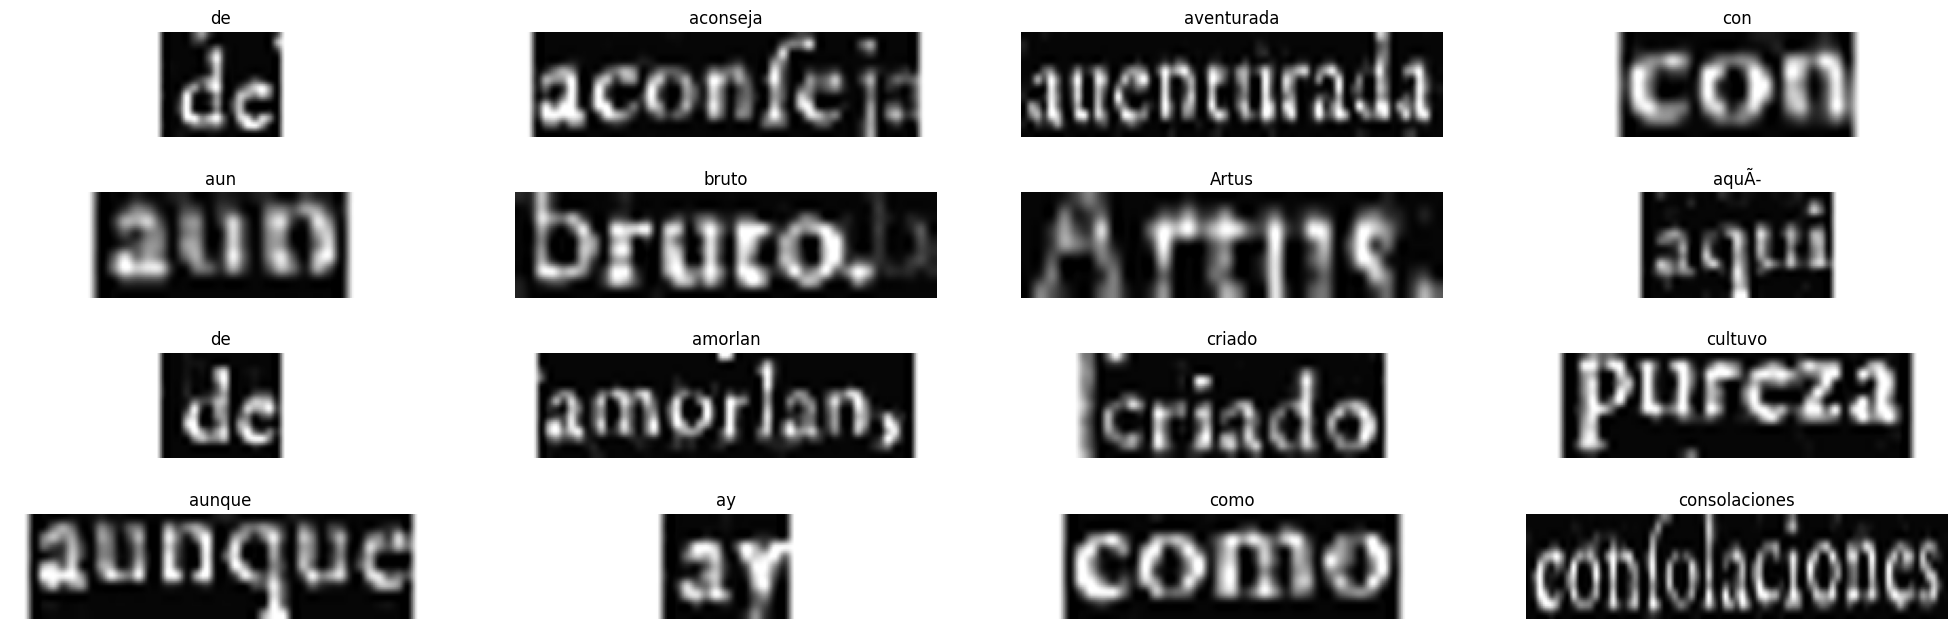

In [34]:
show_images(data=train_ds, cmap='gray')

# **Model Definition**

### Defines a custom Keras layer that computes and adds the Connectionist Temporal Classification (CTC) loss to the model for training sequence-to-sequence prediction tasks.

In [35]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

### Decodes the predicted labels from the OCR model, converting numeric values back to characters and removing unknown tokens to produce the final text output.

In [36]:
def decode_pred(pred_label):

    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability
    for each character. The function uses CTC decoding to decode the numeric labels back into their
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.

    Argument :
        pred_label : These are the model predictions which are needed to be decoded.

    Return:
        filtered_text : This is the list of all the decoded and processed predictions.

    '''

    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

### This code defines a deep learning model for optical character recognition (OCR) using a combination of convolutional neural networks (CNNs) for feature extraction and bidirectional long short-term memory (LSTM) networks for sequence learning, concluding with a custom CTC loss layer for training.

In [37]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

In [38]:
# Model Summary
ocr_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 100, 25, 32)          0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 100, 25, 64)          18496     ['max_pooling2d_2[0][0]'

In [27]:
tf.keras.utils.plot_model(ocr_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Compiles the OCR model with the Adam optimizer and trains it on the training dataset with validation, using early stopping and model checkpoint callbacks.

In [ ]:
# Compile
ocr_model.compile(optimizer='adam')

# Train
history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

### Creates an inference model from the trained OCR model for making predictions and prints the model summary.

In [27]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

# Model summary
inference_model.summary()

Model: "model_1"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 12, 64)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense (De

In [ ]:
print(decode_pred(inference_model.predict(test_ds))[:10])   #convert to test_ds

In [ ]:
show_images(data=valid_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

### Generates and decodes predictions from the inference model on the test dataset, printing the results in groups of 8 words per line.


In [ ]:
decoded_predictions = decode_pred(inference_model.predict(test_ds))

# Print decoded predictions in groups of 8 words per line (You will have to figure out a better and ideal approach, this is just for sample)
words_per_line = 8
for i in range(0, int(len(decoded_predictions)/10), words_per_line):
    print(' '.join(decoded_predictions[i:i+words_per_line]))

54/54 [==============================] - 1s 11ms/step
a pedede Sayri, trales ela Sto a aniros
do terir- Conrtas, vaa sla a sear pra
dalle Le dii nas ela teca sca ito
pao Sanre casa Conoseste, esda muesra poo o
Lines o po mo aeren h, s prpedad,
aes, ao peli- las macra ao ea cor-
sees ser- hion las  mutos devedo ao
da diescdo canda hos das ho os Eo
taro h laenia, preeton vao piuada rereior gaos
hes, as vose esio certdo veoos, to candles,
cada senalton, aa dandad canteas hays taar visro


## Contributors
- Shashank Shekhar Singh (Indian Institue of Technology, BHU)
- Kate O'Reilly (Trinity College Dublin)
- Utsav Rai (Imperial College London)
- Yukinori Yamamoto (Waseda University)
- Saarthak Gupta (Indian Institute of Technology BHU)
- Pranav Kulkarni (Indinan Institute of Technology, Bombay)
- Arsh Khan (VJTI, Mumbai)
- Xabier Granja (University of Alabama)
- Sergei Gleyzer (University of Alabama)
- Harrison Meadows (University of Tennessee)